In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import json
import keras

In [60]:
date, injection, consommation =[], [], []

json_file = open("bilan-electrique-demi-heure.json", "r")
json_data = json.loads(json_file.read())
for record in json_data :
    json_date = record['fields']['horodate'].replace('T',' ')
    json_date = json_date.replace('00+01:00','00')
    date.append(json_date)
    injection.append(record['fields']['injection_rte'])
    consommation.append(record['fields']['consommation_totale'])
date = pd.DatetimeIndex(pd.to_datetime(date, utc=True)).tz_convert('Europe/Paris')
data = pd.DataFrame(list(zip(consommation)), index = date,columns=['Consommation'])

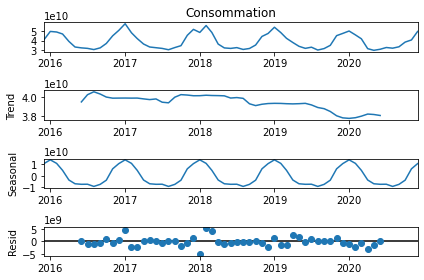

In [3]:
y = data['Consommation'].resample('MS').mean()
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [61]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data = data.sort_index()
data = data.to_numpy()
scaler.fit(data)
data = scaler.transform(data)
X_train = np.stack([data[x:x+50] for x in range(69950)])
y_train = np.stack([data[x+50]for x in range(69950)])
X_valid = [data[x:x+50] for x in range(69950,79950)]
y_valid = [data[x+50]for x in range(69950, 79950)]
X_test = [data[x:x+50] for x in range(79950, len(data)-50)]
y_test = [data[x+50]for x in range(79950, len(data)-50)]

In [65]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True,),
    keras.layers.Dense(1),
])

model.compile(optimizer='adam',
              loss=keras.losses.mean_squared_error)

model.summary()

model.fit(X_train, y_train, epochs=10)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_20 (SimpleRNN)    (None, None, 20)          440       
_________________________________________________________________
simple_rnn_21 (SimpleRNN)    (None, None, 20)          820       
_________________________________________________________________
dense_10 (Dense)             (None, None, 1)           21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2186/2186 [==============================] - 43s 20ms/step - loss: 0.0165
Epoch 2/10
2186/2186 [==============================] - 44s 20ms/step - loss: 0.0053
Epoch 3/10
2186/2186 [==============================] - 46s 21ms/step - loss: 0.0050
Epoch 4/10
2186/2186 [==============================] - 47s 22ms/step - loss: 0.0049
Epoch 5/10
2186/2186 [===================

In [66]:
model.save("Forecasting_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Forecasting_model/assets
